<a href="https://colab.research.google.com/github/ettouilebouael/pdm-thesis/blob/main/FD003_Turbo_Fan_RUL_estimation_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install livelossplot --quiet

from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from skimage.restoration import denoise_wavelet
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import random
from livelossplot import plot_losses

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Memoire/PdM_code")

random.seed(0)
torch.manual_seed(0) 
np.random.seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
def load_data(data_num, online = False):
  sensor_col_names = ['s_%i' % i for i in range(1,22)]
  col_names = ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2','setting_3'] + sensor_col_names
  
  train_path = "CMAPSSData/train_FD00{}.txt".format(str(data_num))
  test_path = "CMAPSSData/test_FD00{}.txt".format(str(data_num))
  RUL_path = "CMAPSSData/RUL_FD00{}.txt".format(str(data_num))

  if online == True:
    test  = pd.read_csv(test_path , sep = "\s+", header=None, names = col_names, index_col=False).dropna(axis = 1)
    RUL_test = pd.read_csv(RUL_path, sep = "\s+", header= None, names = ["true_rul"], index_col= False).reset_index().rename(columns = {"index" :"unit_number"})
    RUL_test.unit_number = RUL_test.unit_number + 1 
    return test , RUL_test
  else:
    train  = pd.read_csv(train_path , sep = " ", header=None, names = col_names, index_col=False).dropna(axis = 1)
    return train

def compute_rul(df):
    a = df[['unit_number' , 'time_in_cycles']].groupby('unit_number').max()
    a = a.rename({"time_in_cycles" : "max_cyles"}, axis = 1)
    b = df.join(a, on = 'unit_number', how='outer', lsuffix=" ")
    df['rul'] = b.max_cyles - b.time_in_cycles
    df['rul'] = df['rul'].clip(upper = 125)
    return df

def gen_sequence(df, unit, seq_len, features):
  X =  df[df.unit_number == unit][features].values
  num_elements = X.shape[0]
  for start, stop in zip(range(0, num_elements-seq_len + 1), range(seq_len, num_elements +1)):
       yield X[start:stop]

def gen_labels(df, seq_len):
    y = df['rul'].values
    return y[seq_len - 1:]

def get_lstm_data(df, features, seq_len):
  X = [[seq.tolist() for seq in gen_sequence(df,unit ,seq_len,features)] for unit in df.unit_number.unique() if len(df[df.unit_number == unit]) > seq_len]
  y = [gen_labels(df[df.unit_number == unit], seq_len).tolist() for unit in df.unit_number.unique() if len(df[df.unit_number == unit]) > seq_len]

  return np.concatenate(X).astype(float), np.concatenate(y).astype(float)

def condition_scaler(df):
  scaler = MinMaxScaler(feature_range=(-1,1))
  sensor_col_names = ['s_%i' % i for i in range(1,22)]

  df['setting_1'] = df['setting_1'].round(1)
  df['setting_2'] = df['setting_2'].round(1)
  df['setting_3'] = df['setting_3'].round(1)
  
  df['op_cond'] = df['setting_1'].astype(str) + '_' + \
                    df['setting_2'].astype(str) + '_' + \
                      df['setting_3'].astype(str)

  for condition in df['op_cond'].unique():
      scaler.fit(df.loc[df['op_cond']==condition, sensor_col_names])
      df.loc[df['op_cond']==condition, sensor_col_names] = scaler.transform(df.loc[df['op_cond']==condition, sensor_col_names])


  #df[features] = scaler.fit_transform(df[features])
    
  return df

def denoise(df, features):
  df[features] = df.groupby('unit_number')[features].apply(lambda x: x.ewm(30).mean()).values
  def create_mask(data, samples):
    result = np.ones_like(data)
    result[0:samples] = 0
    return result
    
  mask = df.groupby('unit_number')['unit_number'].transform(create_mask, samples=0).astype(bool)
  df = df[mask]
    
  return df

def train_preprocessing(data_num,features, seq_len):
  train = load_data(data_num)
  X = compute_rul(train)
  X = denoise(X,features)
  X = condition_scaler(X)
  X_train, y_train = get_lstm_data(X, features, seq_len)
  return X_train, y_train.reshape(-1,1)

def get_online_test_unit(df, features, seq_len):
  X = []
  for i in features:
    online_test_unit = []
    x = []
    for unit in df.unit_number.unique():
      signal = df[i][df.unit_number == unit].values.tolist()
      if len(signal) >= seq_len :
        x.append(signal[-seq_len:])
        online_test_unit.append(unit)
    X.append(x)
  return np.array(X).transpose(1,2,0), list(set(online_test_unit))

def online_preprocessing(data_num, features, seq_len):
  online_df , rul = load_data(data_num=data_num, online = True)
  X = denoise(online_df,features)
  X_online_scaled = condition_scaler(online_df)
  X_online, online_test_unit = get_online_test_unit(X_online_scaled, features, seq_len)
  y_online = rul.true_rul[rul.unit_number.isin(online_test_unit)].clip(upper = 125).values
  return X_online , y_online.reshape(-1,1)

def get_online_indexes(df,seq_len):
  ids = []
  for unit in df.unit_number.unique():
    if len(df[df.unit_number == unit]) > seq_len :
      indexes = df[df.unit_number == unit].index.values
      indexes = indexes[seq_len - 1:]
      ids.extend(indexes)
  return ids
 
def annotate_online_data(X,y):
  rul = []
  for unit in X.unit_number.unique():
    last_rul = y[y.unit_number == unit].true_rul.values[0]
    first_rul = last_rul + len(X[X.unit_number == unit]) + 1
    unit_rul = np.arange(first_rul, last_rul + 1, -1).tolist()
    rul.extend(unit_rul)
  return np.array(rul).clip(1,125)

def get_online_unit(df, seq_len):
  units = []
  for unit in df.unit_number.unique():
    if len(df[df.unit_number == unit]) > seq_len:
      units.extend(unit)
  return units

def online_pipeline(data_num,features, seq_len):
  online_df , y = load_data(data_num,online=True)
  online_df["rul"] = annotate_online_data(online_df , y)
  online_df = denoise(online_df,features)
  online_df = condition_scaler(online_df)
  ids_in = get_online_indexes(online_df, seq_len)
  ids_all = online_df.index.values
  online_df_pred = online_df[np.isin(ids_all,ids_in)]
  X , y = get_lstm_data(online_df, features, seq_len)
  return X, y.reshape(-1,1), online_df_pred 


In [67]:
features =['s_2', 's_3', 's_4', 's_7', 's_8', 's_9','s_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

seq_len = 30
data_num = 3
batch_size = 128
learning_rate = 1e-4
epochs = 15
dropout = 0
input_size = len(features)
n_lstm_layers = 3
n_hidden_lstm = 32

In [68]:
X_train, y_train = train_preprocessing(data_num,features, seq_len)
X_test, y_test = online_preprocessing(data_num,features, seq_len)

In [69]:
class TurboFanDataset(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y
    
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, ix):
    return torch.from_numpy(self.X[ix,:,:]).float() , torch.from_numpy(np.array(self.y[ix])).float()

dataset = {
    'train': TurboFanDataset(X_train, y_train),
    'test': TurboFanDataset(X_test, y_test)}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=batch_size),
     'test': DataLoader(dataset['test'], shuffle=False, batch_size=batch_size)}


In [70]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=n_hidden_lstm, num_layers = n_lstm_layers, batch_first = True, dropout = 0)

  def forward(self, x):
    output, (h, c) = self.lstm(x)
    x = h[-1].reshape(-1,n_hidden_lstm)
    x = F.relu(x)
    return x

class RULPredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(n_hidden_lstm, 64)
    self.fc2 = torch.nn.Linear(64, 32)
    self.fc3 = torch.nn.Linear(32, 16)
    self.output = torch.nn.Linear(16, 1)
    self.dropout = torch.nn.Dropout(p=dropout)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x - self.dropout(x)
    x = self.fc2(x)
    x = F.relu(x)
    x - self.dropout(x)
    x = self.fc3(x)
    x = F.relu(x)
    x - self.dropout(x)
    x = self.output(x)
    return x

encoder = Encoder()
rul_predictor  = RULPredictor()

X = torch.randn(batch_size, seq_len, input_size)

h = encoder(X)
y = rul_predictor(h)

print(y.shape)

torch.Size([128, 1])


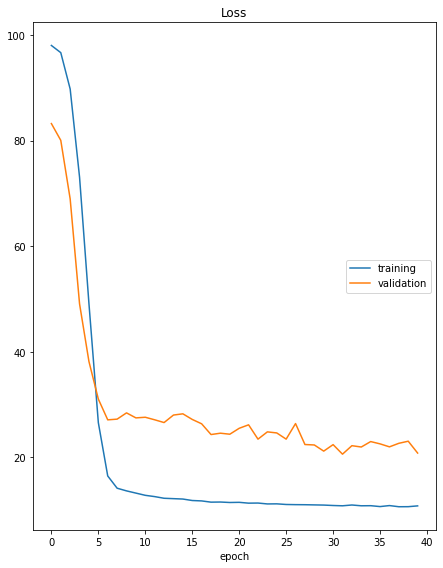

Loss
	training         	 (min:   10.664, max:   98.035, cur:   10.826)
	validation       	 (min:   20.621, max:   83.240, cur:   20.831)


In [71]:
def fit(encoder, rul_predictor, dataloader, epochs, learning_rate, data_num):
  
    device = "cuda" if torch.cuda.is_available() else "cpu"
    liveloss = PlotLosses()
    encoder.to(device)
    rul_predictor.to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(rul_predictor.parameters()), lr=learning_rate,weight_decay=0.001)
    criterion = torch.nn.MSELoss()
    best_loss = 30
    for epoch in range(1, epochs+1):
        encoder.train()
        rul_predictor.train()
        train_loss = []
        eval_loss = []
        logs = {}
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            h_hat = encoder(X)
            y_hat = rul_predictor(h_hat)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        encoder.eval()
        rul_predictor.eval()
        with torch.no_grad():
          for batch in dataloader['test']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            h_hat = encoder(X)
            y_hat = rul_predictor(h_hat)
            loss = criterion(y_hat, y)
            eval_loss.append(loss.item())

            rmse_train = np.sqrt(np.mean(train_loss))
            rmse_val = np.sqrt(np.mean(eval_loss))

          logs["loss"] = rmse_train
          logs["val_loss"] = rmse_val

          liveloss.update(logs)
          liveloss.send()

          if epoch > 25 :
            if best_loss > rmse_val:
              best_loss = rmse_val
              torch.save(encoder.state_dict(), f"models/fd00{data_num}/encoder_fd00{data_num}_rmse_{rmse_val}")
              torch.save(rul_predictor.state_dict(), f"models/fd00{data_num}/rul_predictor_fd00{data_num}_rmse_{rmse_val}")
              print(f'best model saved with rmse = {rmse_val} at epoch {epoch}')


fit(encoder, rul_predictor, dataloader, 40, learning_rate, data_num)

rmse : 20.000879649844858


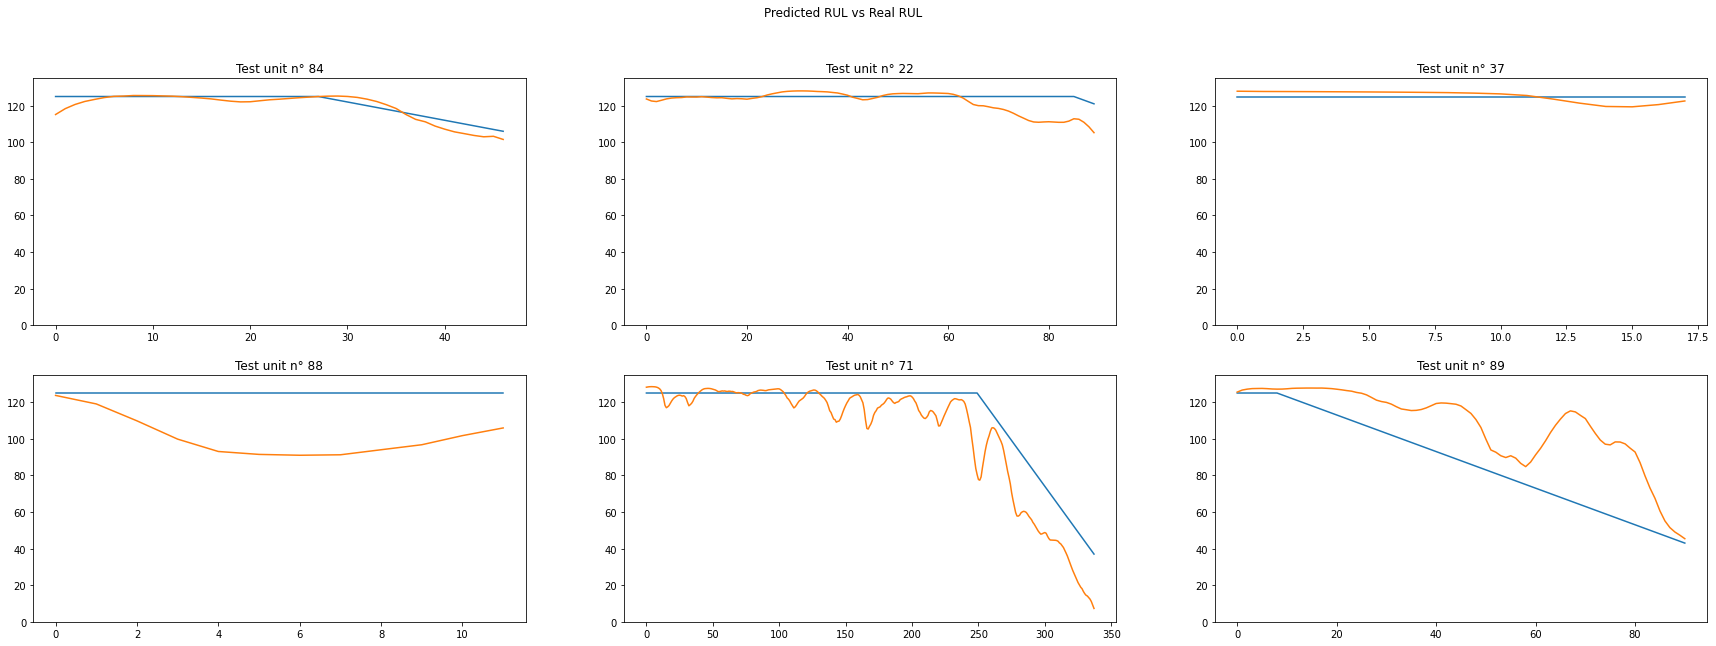

In [72]:
# plot rul predictions for random engines from test units
def plot_test_predictions(encoder, rul_predictor,data_num,features, seq_len):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  X , y, online_df_pred = online_pipeline(data_num, features, seq_len)
  loss = torch.nn.MSELoss()
  rul_predictor.eval()
  encoder.eval()
  rul_predictor.to(device)
  encoder.to(device)
  with torch.no_grad():
    X = torch.from_numpy(X).float().to(device)
    y = torch.from_numpy(y).float().to(device)
    h_hat = encoder(X)
    y_pred = rul_predictor(h_hat)
    mse = loss(y_pred, y)
    online_df_pred.loc[:,'rul_pred'] = y_pred.cpu().numpy()
  units =  np.random.randint(1,100,6) 
  fig, axs = plt.subplots(2, 3, figsize=(30,10))
  fig.suptitle('Predicted RUL vs Real RUL')
  for ax, unit in zip(axs.flatten(), units):
    ax.plot(online_df_pred[online_df_pred.unit_number ==  unit]['rul'].values)
    ax.plot(online_df_pred[online_df_pred.unit_number ==  unit]['rul_pred'].values)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=135)
    ax.set_title(f'Test unit n° {unit}')
  plt.plot()
  
  print('rmse :', np.sqrt(mse.item()))

plot_test_predictions(encoder, rul_predictor, data_num,features,seq_len)